In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary

from torchvision.models import vgg11_bn, VGG11_BN_Weights

from ignite.engine import create_supervised_trainer
from ignite.handlers import FastaiLRFinder

import numpy as np

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

import os
import random
from copy import deepcopy
import time
import datetime
from tqdm.notebook import tqdm

### 0. Helper Functions

In [ ]:
from random import seed as randSeed

from numpy.random import seed as npSeed
from torch import manual_seed
from torch.cuda import manual_seed_all


def seed_everything(seed: int):
    r"""Sets the seed for generating random numbers in PyTorch, numpy and
    Python.
    Args:
        seed (int): The desired seed.
    """
    randSeed(seed)
    npSeed(seed)
    manual_seed(seed)
    manual_seed_all(seed)

In [ ]:
def plot_tensor_image(tensor):
    image = torch.permute(tensor, (1, 2, 0))
    plt.imshow(np.array(image))
    plt.axis('off')

In [ ]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

### 1. Explore the Dataset

In [ ]:
TRAIN_DIR = os.path.join(os.getcwd(), "data", "train")
TEST_DIR = os.path.join(os.getcwd(), "data", "val")
CLASSES = os.listdir(TRAIN_DIR)

We have 2 classes in our dataset; 'Cracks', 'Groove'. The images of each are located in the folder of their classes.

In [ ]:
for label in CLASSES:
    class_path = os.path.join(TRAIN_DIR, label)
    print("Class {} has {} images".format(label, len(os.listdir(class_path))))

Class Cracks has 1620 images
Class Groove has 1620 images


We have 1620 images for each class. No class-imbalance problem exists.

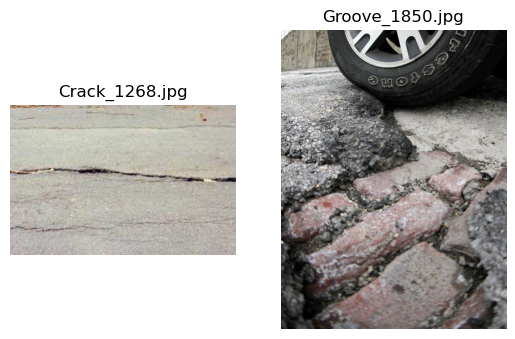

In [ ]:
crack_images_paths = os.listdir(os.path.join(TRAIN_DIR, "Cracks"))
groove_images_paths = os.listdir(os.path.join(TRAIN_DIR, "Groove"))

CRACK_RANDOM_IMAGE_IDX = random.randint(0, 1619)
GROOVE_RANDOM_IMAGE_IDX = random.randint(0, 1619)

plt.subplot(1, 2, 1)
crack_image_path = os.path.join(TRAIN_DIR, "Cracks", crack_images_paths[CRACK_RANDOM_IMAGE_IDX])
crack_image = Image.open(crack_image_path)
plt.imshow(np.array(crack_image))
plt.title(crack_images_paths[CRACK_RANDOM_IMAGE_IDX])
plt.axis('off')

plt.subplot(1, 2, 2)
groove_image_path = os.path.join(TRAIN_DIR, "Groove", groove_images_paths[GROOVE_RANDOM_IMAGE_IDX])
groove_image = Image.open(groove_image_path)
plt.imshow(np.array(groove_image))
plt.title(groove_images_paths[GROOVE_RANDOM_IMAGE_IDX])
plt.axis('off')

plt.show()

We can load the dataset using the `ImageFolder` class from `torchvision.datasets` as it's the most suitable with the directory structure we have right now. Before that we need to define some image transforms in addition to the transforms of the pretrained model we are going to use.

### 2. Model

For this notebook, we are going to use VGG_11_BN pretrained network and train the classifier part in the model while freezing the feature extractor part.

**Note: We can use the same logic to train different models later.**

In [ ]:
weights = VGG11_BN_Weights.IMAGENET1K_V1
vgg_11_bn_model = vgg11_bn(weights = weights)
preprocess = weights.transforms()
print("The transforms used for {} are\n{}".format(weights, preprocess))

The transforms used for VGG11_BN_Weights.IMAGENET1K_V1 are
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
print(vgg_11_bn_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### 3. Image Transforms

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    preprocess
])

In [ ]:
test_transforms = preprocess

### 4. Loading Data

In [ ]:
train_dataset = ImageFolder(TRAIN_DIR, transform = train_transforms)

In [ ]:
test_dataset = ImageFolder(TEST_DIR, transform = test_transforms)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [ ]:
for images, labels in train_dataloader:
    print(images.shape)
    print(labels)
    break

torch.Size([16, 3, 224, 224])
tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])


### 5. Modfying the Model

We want to freeze the feature extractor part and replace the classifier part with trainable network.

In [ ]:
for param in vgg_11_bn_model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [ ]:
freeze_model(vgg_11_bn_model)

In [ ]:
for param in vgg_11_bn_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
vgg_11_bn_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=128, out_features=128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=128, out_features=2)
)

In [ ]:
for param in vgg_11_bn_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [ ]:
def loss_batch(criterion, output, target, optimizer = None,scheduler = None):
    with torch.set_grad_enabled(optimizer is not None):
        loss = criterion(output, target)
        predictions = output.argmax(dim = 1, keepdim = True)
        correct = predictions.eq(target.view_as(predictions)).sum().item()
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        return loss.item(), correct

In [ ]:
def loss_epoch(model, dataloader, criterion, device, optimizer = None, scheduler = None):
    running_loss = 0.0
    running_acc = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(optimizer is not None):
            output = F.log_softmax(model(images), dim = 1)
            batch_loss, batch_acc = loss_batch(criterion, output, labels, optimizer, scheduler)
            running_loss += batch_loss
            running_acc += batch_acc
    epoch_loss = running_loss / len(dataloader.sampler)
    epoch_acc = running_acc / len(dataloader.sampler)
    return epoch_loss, epoch_acc

In [ ]:
def train(model, epochs, train_loader, test_loader, criterion, optimizer, scheduler):
    current_timestamp = f"{datetime.datetime.now():%Y%m%d}"
    results_path = os.path.join(os.getcwd(), "weights", current_timestamp)
    if not os.path.exists(results_path):
        os.makedirs(results_path)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    best_acc = -1
    best_weights = None
    t = time.time()
    for epoch in range(epochs):
        print("Eoch {}/{}".format(epoch, epochs-1))
        model.train()
        epoch_loss, epoch_acc = loss_epoch(model, train_loader, criterion, device, optimizer, scheduler)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        print("Train:\tLoss:{:.6f}\tAccuracy:{:.6f}".format(epoch_loss, epoch_acc))
        model.eval()
        epoch_loss, epoch_acc = loss_epoch(model, test_loader, criterion, device, None, None)
        test_loss.append(epoch_loss)
        test_acc.append(epoch_acc)
        print("Test:\tLoss:{:.6f}\tAccuracy:{:.6f}".format(epoch_loss, epoch_acc))
        print("Current LR: {}".format(optimizer.param_groups[0]["lr"]))
        print('-' * 75)
        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            torch.save(vgg_11_bn_model.state_dict(), f"{results_path}/best_model.pt")
    
    model.load_state_dict(torch.load(f"{results_path}/best_model.pt"))
    return {
        "best_model": model,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "test_loss": test_loss,
        "test_acc": test_acc
    }

In [ ]:
criterion = nn.NLLLoss(reduction="sum")
optimizer = optim.Adam(vgg_11_bn_model.parameters())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_11_bn_model = vgg_11_bn_model.to(device)

In [ ]:
trainer = create_supervised_trainer(vgg_11_bn_model, optimizer, criterion, device=device)

In [ ]:
lr_finder = FastaiLRFinder()
to_save = {"model": vgg_11_bn_model, "optimizer": optimizer}
with lr_finder.attach(trainer, to_save, end_lr=1e-02) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_dataloader)

C:\Users\U\anaconda3\envs\conda-torch\lib\site-packages\ignite\handlers\lr_finder.py:197: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


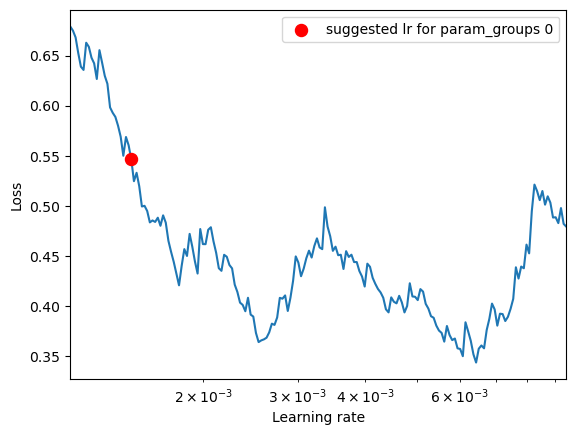

<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>

In [ ]:
lr_finder.plot()

In [ ]:
max_lr = lr_finder.lr_suggestion()

In [ ]:
optimizer = optim.Adam(vgg_11_bn_model.parameters(), lr = max_lr / 20)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=25, steps_per_epoch=len(train_dataloader))

In [ ]:
result = train(vgg_11_bn_model, 25, train_dataloader, test_loader, criterion, optimizer, scheduler)

  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.187721	Accuracy:0.935185


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.152830	Accuracy:0.945679
Current LR: 0.00011992839281733557
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.202655	Accuracy:0.924383


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.150808	Accuracy:0.937037
Current LR: 0.00029266501088336745
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.196272	Accuracy:0.927469


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.150799	Accuracy:0.943210
Current LR: 0.0005471264951040409
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.188118	Accuracy:0.932407


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.187522	Accuracy:0.930864
Current LR: 0.000839257137714343
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.213816	Accuracy:0.921605


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.136332	Accuracy:0.950617
Current LR: 0.0011184794524614467
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.180821	Accuracy:0.927160


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.197889	Accuracy:0.924691
Current LR: 0.0013364508120214417
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.190942	Accuracy:0.929630


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.148908	Accuracy:0.951852
Current LR: 0.0014554331573425705
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.174923	Accuracy:0.931173


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.149776	Accuracy:0.938272
Current LR: 0.0014675580976647841
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.180895	Accuracy:0.938580


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.127878	Accuracy:0.959259
Current LR: 0.0014439058666215596
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.168868	Accuracy:0.942284


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.119508	Accuracy:0.956790
Current LR: 0.0013974781802934102
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.163032	Accuracy:0.942284


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.182468	Accuracy:0.935802
Current LR: 0.0013297672627197504
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.145275	Accuracy:0.949074


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.121564	Accuracy:0.955556
Current LR: 0.001242949398504126
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.138083	Accuracy:0.957407


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.127410	Accuracy:0.958025
Current LR: 0.0011398149852364038
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.133368	Accuracy:0.951235


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.135200	Accuracy:0.945679
Current LR: 0.0010236788478182868
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.123272	Accuracy:0.954938


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.112062	Accuracy:0.960494
Current LR: 0.0008982736972635246
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.114926	Accuracy:0.958642


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.115291	Accuracy:0.955556
Current LR: 0.0007676301582946492
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.109589	Accuracy:0.959259


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.124694	Accuracy:0.956790
Current LR: 0.0006359472217479823
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.098321	Accuracy:0.961420


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.127983	Accuracy:0.958025
Current LR: 0.0005074572855532148
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.102076	Accuracy:0.965432


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.126034	Accuracy:0.958025
Current LR: 0.0003862901219815179
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.097644	Accuracy:0.968827


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.125839	Accuracy:0.954321
Current LR: 0.00027634014336676066
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.073763	Accuracy:0.970679


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.122247	Accuracy:0.959259
Current LR: 0.0001811412324887649
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.067073	Accuracy:0.972222


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.126544	Accuracy:0.960494
Current LR: 0.00010375316067307434
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.073931	Accuracy:0.974383


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.124161	Accuracy:0.961728
Current LR: 4.666324422296256e-05
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.078237	Accuracy:0.971914


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.129245	Accuracy:0.959259
Current LR: 1.1706400026875903e-05
---------------------------------------------------------------------------


  0%|          | 0/203 [00:00<?, ?it/s]

Train:	Loss:0.075008	Accuracy:0.973148


  0%|          | 0/51 [00:00<?, ?it/s]

Test:	Loss:0.125802	Accuracy:0.960494
Current LR: 6.16981986408871e-09
---------------------------------------------------------------------------


AttributeError: 'VGG' object has no attribute 'load_stat_dict'

In [ ]:
vgg_11_bn_model.load_state_dict(torch.load("weights/20221116/best_model.pt"))

<All keys matched successfully>

In [ ]:
train_dataset.class_to_idx

{'Cracks': 0, 'Groove': 1}

In [ ]:
class TestDataset(Dataset):
    def __init__(self, folder_path, transforms):
        self.images_names = [image_name for image_name in os.listdir(folder_path)]
        self.folder_path = folder_path
        self.transforms = transforms
    def __len__(self):
        return len(self.images_names)
    def __getitem__(self, idx):
        image_name = self.images_names[idx]
        image = self.transforms(Image.open(os.path.join(self.folder_path, image_name)))
        label = 0
        if "Crack" in image_name:
            label = 0
        elif "Groove" in image_name:
            label = 1
        return image, torch.tensor(label)

In [ ]:
evaluation_dataset = TestDataset(os.path.join(os.getcwd(), "data", "test"), preprocess)

In [ ]:
evaluation_dataset[400]

(tensor([[[-0.1314, -0.1828, -0.1657,  ..., -0.5424, -0.5767, -0.6281],
          [-0.0801, -0.1999, -0.1314,  ..., -0.5253, -0.5596, -0.5767],
          [-0.1486, -0.3027, -0.3883,  ..., -0.4226, -0.4911, -0.5253],
          ...,
          [-0.4739, -0.4054, -0.3883,  ..., -0.5596, -0.5424, -0.4568],
          [-0.5082, -0.4054, -0.4226,  ..., -0.4911, -0.4911, -0.4739],
          [-0.4226, -0.4226, -0.4911,  ..., -0.4911, -0.4739, -0.4739]],
 
         [[-0.1099, -0.1450, -0.1099,  ..., -0.4251, -0.4601, -0.5126],
          [-0.0224, -0.0924, -0.0049,  ..., -0.4076, -0.4426, -0.4601],
          [-0.0049, -0.1275, -0.1975,  ..., -0.3025, -0.3725, -0.4076],
          ...,
          [-0.2675, -0.1975, -0.1800,  ..., -0.3725, -0.3550, -0.2675],
          [-0.3025, -0.1975, -0.2150,  ..., -0.3025, -0.3025, -0.2850],
          [-0.2150, -0.2150, -0.2850,  ..., -0.3025, -0.2850, -0.2850]],
 
         [[-0.0964, -0.1312, -0.0964,  ..., -0.2010, -0.2358, -0.3055],
          [-0.0092, -0.0964,

In [ ]:
def evaluate(model, test_dataloader):
    true_values_list = []
    pred_probs_list = []
    pred_labels_list = []
    for images, labels in test_dataloader:
        for label in labels.data:
            true_values_list.append(label.item())
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            for prediction in F.softmax(outputs, dim=1).data.cpu():
                pred_probs_list.append(prediction.numpy().tolist())
            pred_labels = outputs.argmax(dim = 1, keepdim = True)
            for pred_label in pred_labels.data.cpu():
                pred_labels_list.append(pred_label.item())
    return true_values_list, np.array(pred_probs_list), pred_labels_list

In [ ]:
evaluation_dataloader = DataLoader(evaluation_dataset, batch_size = 16, shuffle = False)

In [ ]:
true_values_list, pred_probs_list, pred_labels_list = evaluate(vgg_11_bn_model, evaluation_dataloader)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

In [ ]:
accuracy_score(true_values_list, pred_labels_list)

0.96

In [ ]:
tn, fp, fn, tp = confusion_matrix(true_values_list, pred_labels_list).ravel()
print(f"True Negatives: {tn}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Positives: {tp}")

True Negatives: 218
False Positives: 7
False Negatives: 11
True Positives: 214


In [ ]:
precision_score(true_values_list, pred_labels_list)

0.9683257918552036

In [ ]:
recall_score(true_values_list, pred_labels_list)

0.9511111111111111

In [ ]:
f1_score(true_values_list, pred_labels_list)

0.9596412556053812

In [ ]:
roc_auc_score(true_values_list, pred_probs_list[:, 1])

0.9943506172839506